Imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import csv
import re
from utils import *
from vhparser import *

Obtain the list of entries in the VHDB and parse it

In [3]:
entries = getListOfEntries("virushostdb.tsv")
myEntries = MyVHDB.fromVHDBEntries(entries)

Determine the number of unique host species and virus species:

In [4]:
def countHosts(myvhdb):
    counter = Counter()
    for key, record in myvhdb.items():
        for host in record.hosts:
            counter.add(host.name, 1)

    return counter

hostCounter = countHosts(myEntries)
print("Number of unique Viruses: %d" % len(myEntries.keys()))
print("Number of unique Hosts:   %d" % hostCounter.numPresentKeys())

Number of unique Viruses: 11040
Number of unique Hosts:   3119


Determine how many viruses infect humans or at least one domesticated animal species:

Number of Viruses that Infect at Least One Metazoan: 4254
Number of Viruses that Infect At Least One Domesticated Animal Host: 384
Number of Viruses that Infect Humans: 1309
Number of Viruses that Infect Both: 19
Number of viruses that infect at least one plant: 2141
Number of viruses that infect at least one domesticated plant: 1250


NameError: name 'only_domestic' is not defined

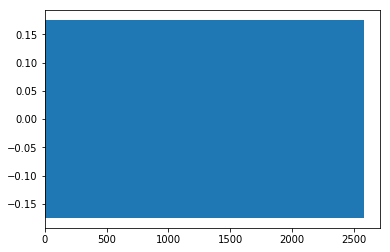

In [14]:
# Name records sometimes abbreviate the genus name (e.g. "A. mellifera") and sometimes contain multiple species in the format "speciesA x speciesB x ...".
# Also, sometimes "sp." or "spp." is used instead of the name of a specific species.
# This method extracts all names and possible abbreviations for them.
def getSpeciesNamesFromNameRecord(name):
    #species_names = name.split(" x ")
    species_names = re.split(" x |, ", name)
    orig_length = len(species_names)
    for species_name in species_names[:orig_length]:
        split_name = species_name.split(' ')
        if len(split_name) > 1:
            abbrev_genus = "{}.".format(split_name[0][0])
            for n in split_name[1:]:
                abbrev_genus = "{} {}".format(abbrev_genus, n)
            
            species_names.append(abbrev_genus)
            
            sp_genus = "{} sp.".format(split_name[0])
            spp_genus = "{} spp.".format(split_name[0])
            species_names.append(sp_genus)
            species_names.append(spp_genus)
    
    return species_names

def getDomesticatedAnimals(infile):
    domesticated_animals = []
    
    with open(infile) as dafile:
        reader = csv.reader(dafile)
        domesticated_animals = list(reader)[0]
            
    return domesticated_animals;

DOMESTICATED_ANIMALS = getDomesticatedAnimals("Domesticated-Animals.csv")

def countInfectsAtLeastOneMetazoan(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            if 'Metazoa' in host.lineage:
                count = count + 1
                break
                
    return count

def countInfectsAtLeastOneDomesticatedAnimal(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            counted = False
            host_names = getSpeciesNamesFromNameRecord(host.name)
            for host_name in host_names:
                if (host_name in DOMESTICATED_ANIMALS):
                    counted = True
                    
            if counted: count = count + 1
    
    return count

def countInfectsHumans(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            counted = False
            host_names = getSpeciesNamesFromNameRecord(host.name)
            for host_name in host_names:
                if host_name == "Homo sapiens":
                    counted = True
                    
            if counted: count = count + 1
                    
    
    return count

def countInfectsHumansAndAtLeastOneDomesticatedAnimal(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        hum = False
        dom = False
        for host in record.hosts:
            counted = False
            host_names = getSpeciesNamesFromNameRecord(host.name)
            for host_name in host_names:
                if host_name == "Homo sapiens":
                    hum = True
                elif host_name in DOMESTICATED_ANIMALS:
                    dom = True
        if hum and dom:
            count = count + 1
            
    return count

infects_at_least_one_metazoan = countInfectsAtLeastOneMetazoan(myEntries)
infects_at_least_one_domesticated_animal = countInfectsAtLeastOneDomesticatedAnimal(myEntries)
infects_humans = countInfectsHumans(myEntries)
infects_humans_and_at_least_one_domesticated_animal = countInfectsHumansAndAtLeastOneDomesticatedAnimal(myEntries)

print("Number of Viruses that Infect at Least One Metazoan: %d" % infects_at_least_one_metazoan)
print("Number of Viruses that Infect At Least One Domesticated Animal Host: %d" % infects_at_least_one_domesticated_animal)
print("Number of Viruses that Infect Humans: %d" % infects_humans)
print("Number of Viruses that Infect Both: %d" % infects_humans_and_at_least_one_domesticated_animal)

def getDomesticatedPlants(infile):
    domesticated_plants = []
    
    with open(infile) as dpfile:
        reader = csv.reader(dpfile)
        for line in reader:
            species_names = line[1].split(', ')
            for name in  species_names:
                if name not in domesticated_plants:
                    domesticated_plants.append(name)
            
    return domesticated_plants

DOMESTICATED_PLANTS = getDomesticatedPlants("allplants.csv")

def countInfectsAtLeastOnePlant(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            if 'Viridiplantae' in host.lineage:
                count = count + 1
                break
    
    return count

def countInfectsAtLeastOneDomesticatedPlant(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            counted = False
            host_names = getSpeciesNamesFromNameRecord(host.name)
            for host_name in host_names:
                if (host_name in DOMESTICATED_PLANTS):
                    counted = True
                    
            if counted: count = count + 1
    
    return count

infects_at_least_one_plant = countInfectsAtLeastOnePlant(myEntries)
infects_at_least_one_domesticated_plant = countInfectsAtLeastOneDomesticatedPlant(myEntries)

print("Number of viruses that infect at least one plant: {}".format(infects_at_least_one_plant))
print("Number of viruses that infect at least one domesticated plant: {}".format(infects_at_least_one_domesticated_plant))


def plotInfectsHumansDomesticatedAnimals(total_animals, humans, domesticated_animals, both):
    wild_animals = total_animals - (humans + domesticated_animals - both)
    only_domestic_animals = domesticated_animals - both
    only_humans = humans - both
    
    ind = np.arange(1)
    
    fig, ax = plt.subplots()
    pWild = ax.barh(ind, wild_animals, height = 0.35, align='center')
    pDomestic = ax.barh(ind, only_domestic_animals, left=wild_animals, height = 0.35, align='center')
    pBoth = ax.barh(ind, both, left=wild_animals+only_domestic_animals, height = 0.35, align='center')
    pHumans = ax.barh(ind, only_humans, left=wild_animals+only_domestic_animals+both, height = 0.35, align='center')
    ax.legend( (pWild, pDomestic, pBoth, pHumans), ("Infects only wild animals", "Infects at least one domesticated animal", "Infects both humans and at least one domesticated animal", "Infects humans"))
    ax.set_ylim(-0.2,0.8)
    plt.yticks(ind, ("Animals"))
    ax.set_title('Viruses Species which Infect Different Classes of Animal')
    ax.set_xlabel('Number of Virus Species')

    
plotInfectsHumansDomesticatedAnimals(infects_at_least_one_metazoan, infects_humans, infects_at_least_one_domesticated_animal, infects_humans_and_at_least_one_domesticated_animal)


Make a bar graph showing unique species of virus and host

In [ ]:
def makeUniqueVirusesHostsPlot(uniqueViruses, uniqueHosts):
    cats = ('Viruses', 'Hosts')
    y_pos = np.arange(len(cats))
    x_pos = (uniqueViruses, uniqueHosts)

    fig, ax = plt.subplots()

    bars = ax.bar(y_pos, x_pos, align='center', alpha = 0.5, tick_label=cats)
    ax.set_xticks(y_pos, cats)
    ax.set_ylabel('Number of Unique Species')
    ax.set_title('Unique Species of Viruses and Hosts in the Database')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height-1000, '%d' % int(height), ha='center', va='bottom')
        
makeUniqueVirusesHostsPlot(len(myEntries.keys()), hostCounter.numPresentKeys())

Make a cumulative distribution showing number of hosts per virus

In [ ]:
def logHandleZero(value):
    if value == 0:
        return 0
    else:
        return math.log(value)

def hostsPerVirusPlot(myEntries):
    counts = []
    largest = 0
    for key, record in myEntries.items():
        count = len(record.hosts)
        if count > largest:
            largest = count 
        counts.append( float(count) )

    countsArray = np.array(counts)
    bins = np.arange(largest)

    fig, ax = plt.subplots()

    values, base = np.histogram(countsArray, bins=largest)
    cumulative = np.cumsum(values)
    ax.plot(base[:-1], len(countsArray)-cumulative)
    ax.set_yscale('log')
    #ax.plot(base[:-1], [logHandleZero(i) for i in (len(countsArray)-cumulative)])
    
    #hist = ax.hist(countsArray, bins, linewidth=1, histtype='step', cumulative=True, density=True)
    #ax.set_xticks(bins)
    ax.set_ylabel('Log Frequency')
    ax.set_xlabel('Number of Hosts per Virus')
    ax.set_title('Cumulative Distribution of Hosts per Virus')
    
hostsPerVirusPlot(myEntries)

Make a bar graph of the clades species belong to

In [ ]:
def pcc_sort(item):
    return item[1]

def hostCladesPlot(myEntries):
    countedHostIds = []
    cladeCounter = Counter()
    for virus_tax_id, record in myEntries.items():
        for host in record.hosts:
            #print(host)
            if host.tax_id not in countedHostIds:
                countedHostIds.append(host.tax_id)
                #print(host.lineage)
                splitLineage = host.lineage.split('; ')
                if len(splitLineage) < 2:
                    continue
                #print(splitLineage)
                cladeCounter.add((splitLineage[0], splitLineage[1]), 1)

    #print(cladeCounter.dict)

    prunedCladeCounter = Counter()
    for (clade1, clade2), count in cladeCounter.items():
        if count > 100:
            prunedCladeCounter.add( (clade1, clade2), count )
        else:
            prunedCladeCounter.add( (clade1, clade1), count )
    
    #print(prunedCladeCounter.dict)
    pcc_items = sorted(list(prunedCladeCounter.items()), key=pcc_sort, reverse=True)
    
    clades = []
    counts = []
    for (clade1, clade2), count in pcc_items:
        clade = None
        if (clade2 == 'Eukaryota'):
            clade = 'Other Eukaryotes'
        elif (clade2 == 'Bacteria'):
            clade = 'Other Bacteria'
        else:
            clade = clade2
        clades.append(clade)
        counts.append(count)

    fig, ax = plt.subplots()

    y_pos = np.arange(len(clades))
    bars = ax.barh(y_pos, counts, align='center', alpha=0.5, tick_label=clades)
    ax.set_xticks(y_pos, clades)
    ax.set_xlabel('Number of Unique Species')
    ax.set_xlim(0, 1500)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 20, bar.get_y() + bar.get_height()/2., '%d' % int(width), ha='left', va='center')
        #plt.text(bar.get_x() + bar.get_width()/2., height-1000, '%d' % int(height), ha='center', va='bottom')
        
hostCladesPlot(myEntries)

Show how many of those that infect metazoans and plants infect humans and domesticated species specifically

In [ ]:
def domesticatedWildPlot(myEntries):
    countedHostIds = []
    cladeCounter = Counter()
    for virus_tax_id, record in myEntries.items():
        for host in record.hosts:
            #print(host)
            if host.tax_id not in countedHostIds:
                countedHostIds.append(host.tax_id)
                #print(host.lineage)
                splitLineage = host.lineage.split('; ')
                if len(splitLineage) < 2:
                    continue
                #print(splitLineage)
                cladeCounter.add((splitLineage[0], splitLineage[1]), 1)

    #print(cladeCounter.dict)

    prunedCladeCounter = Counter()
    for (clade1, clade2), count in cladeCounter.items():
        if count > 100:
            prunedCladeCounter.add( (clade1, clade2), count )
        else:
            prunedCladeCounter.add( (clade1, clade1), count )
    
    #print(prunedCladeCounter.dict)
    pcc_items = sorted(list(prunedCladeCounter.items()), key=pcc_sort, reverse=True)
    
    